# Controller Validation (Exciter, PSS and Turbine Governor) with 4th Order SG

## Import Libraries

In [1]:
import sys
import os
import urllib.request
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import dpsimpy

## Def. function to calculate $V_d$, $V_q$, $I_d$ and $I_q$ in PSAT

In [2]:
def calculate_variables_psat(ts_psat_4Order):
    #calculate vd and vq
    angle = ts_psat_4Order['delta'].values - ts_psat_4Order['theta_bus1'].values
    V_bus1 = ts_psat_4Order['V_Bus1'].values
    vd = V_bus1 * np.sin(angle)
    ts_psat_4Order['vd'] = TimeSeries('vd', ts_psat_4Order['V_Bus1'].time, vd)
    vq = V_bus1 * np.cos(angle)
    ts_psat_4Order['vq'] = TimeSeries('vq', ts_psat_4Order['V_Bus1'].time, vq)
        
    #calculate id and iq in PSAT
    Xd = 0.299900
    Xq = 0.650000
    i_d = (ts_psat_4Order['eq_t'].values - ts_psat_4Order['vq'].values) / Xd
    ts_psat_4Order['id'] = TimeSeries('id', ts_psat_4Order['eq_t'].time, i_d)
    i_q = -(ts_psat_4Order['ed_t'].values - ts_psat_4Order['vd'].values) / Xq
    ts_psat_4Order['iq'] = TimeSeries('iq', ts_psat_4Order['ed_t'].time, i_q)
    
    return ts_psat_4Order

## Nominal values

In [3]:
#nominal values (per unit)
nominal_values = {}
nominal_values['Te'] = 0.540541
nominal_values['Tm'] = 0.540541
nominal_values['Edq0_0'] = 0.403062     
nominal_values['Edq0_1'] = 0.944802     
nominal_values['Vdq0_0'] = 0.639089
nominal_values['Vdq0_1'] = 0.833106
nominal_values['Idq0_0'] = 0.372443
nominal_values['Idq0_1'] = 0.363119
nominal_values['delta'] = 0.909230
nominal_values['w_r'] = 1.0
nominal_values['Ef'] = 1.507191
nominal_grid_voltage = 24e3

#
titles = {}
titles['Te'] = 'Electrical Torque'
titles['Tm'] = 'Mechanical Torque'
titles['Edq0_0'] = 'd-component of the voltage behind the transient reactance'
titles['Edq0_1'] = 'q-component of the voltage behind the transient reactance'
titles['Vdq0_0'] = 'd-component of the terminal voltage'
titles['Vdq0_1'] = 'q-component of the terminal voltage'
titles['Idq0_0'] = 'd-component of the terminal current'
titles['Idq0_1'] = 'q-component of the terminal current'
titles['delta'] = 'Delta'
titles['w_r'] = 'Mechanical Omega'
titles['Ef'] = 'Exiter output'

#
ylabels = {}
ylabels['Te'] = 'Torque (p.u.)'
ylabels['Tm'] = 'Torque (p.u.)'
ylabels['Edq0_0'] = 'Ed_t (p.u.)'
ylabels['Edq0_1'] = 'Eq_t (p.u.)'
ylabels['Edq0_t_0'] = 'Ed_t (p.u.)'
ylabels['Edq0_t_1'] = 'Eq_t (p.u.)'
ylabels['Edq0_s_0'] = 'Ed_s (p.u.)'
ylabels['Edq0_s_1'] = 'Eq_s (p.u.)'
ylabels['Vdq0_0'] = 'Vd (p.u.)'
ylabels['Vdq0_1'] = 'Vq (p.u.)'
ylabels['Idq0_0'] = 'Id (p.u.)'
ylabels['Idq0_1'] = 'Iq (p.u.)'
ylabels['delta'] = 'Delta (rad)'
ylabels['w_r'] = 'w_r (p.u.)'
ylabels['Ef'] = 'Ef (p.u.)'

## Declare plot function

In [4]:
import matplotlib.pyplot as plt

timestep_common = 10e-6
t_begin = 0
t_end = 10
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

#plot parameters
width = 12
height = 4

def plot_variable(title, varname_dpsim, varname_psat, ts_dpsim, ts_psat, nominal_values, ylabels):
    fig1 = plt.figure(figsize=(width, height))
    dpsim_values = ts_dpsim[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]
    psat_values = ts_psat[varname_psat].interpolate(timestep_common).values[begin_idx:end_idx]
    plt.plot(time, dpsim_values, label='DPSim')
    plt.plot(time, psat_values, '--', label='PSAT')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.ylabel(ylabels[varname_dpsim])
    plt.grid()
    plt.xlim([t_begin, t_end])
    plt.show
    
    #calculate RMSE
    nom_value = nominal_values[varname_dpsim]
    rmse = np.sqrt(((dpsim_values - psat_values) ** 2).mean())
    print('RMSE {:s}  = {:.6f} (pu), which is {:.3f}% of the nominal value = {:.3f} (pu) '.format(varname_dpsim, rmse, rmse/nom_value*100, nom_value))
        
    return rmse/nom_value*100

def plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim, ts_psat, nominal_voltage, ylabels):
    
    #convert dpsim voltage to magnitude value and per-unit for comparison with psat
    dpsim_values_abs_pu = ts_dpsim[varname_dpsim].interpolate(timestep_common).abs().values[begin_idx:end_idx]/nominal_voltage
    psat_values = ts_psat[varname_psat].interpolate(timestep_common).values[begin_idx:end_idx]
    
    fig1 = plt.figure(figsize=(width, height))
    plt.plot(time, dpsim_values_abs_pu, label='DPSim')
    plt.plot(time, psat_values, '--', label='PSAT')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.show
      
     #calculate RMSE
    rmse = np.sqrt(((dpsim_values_abs_pu - psat_values) ** 2).mean())
    print('RMSE {:s}  = {:.6f} (pu), which is {:.3f}% of the nominal value = {:.3f} (pu) '.format(varname_dpsim, rmse, rmse/1.0*100, 1.0))
        
    return rmse/1.0*100


def plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim, ts_psat, nominal_voltage, ylabels):
    #limit rmse to post-fault evaluation
    t_post_begin=1.1
    t_post_end=t_end
    begin_post_idx = int(t_post_begin/timestep_common)
    end_post_idx= int(t_post_end/timestep_common)
    time_post = np.linspace(begin_post_idx, end_post_idx, num=end_post_idx-begin_post_idx)
    
    dpsim_values = ts_dpsim[varname_dpsim].interpolate(timestep_common).phase().values[begin_idx:end_idx]
    dpsim_values_post = dpsim_values[begin_post_idx:end_post_idx]
    psat_values = ts_psat[varname_psat].interpolate(timestep_common).values[begin_idx:end_idx]/np.pi*180
    psat_values_post = psat_values[begin_post_idx:end_post_idx]
    
    fig2 = plt.figure(figsize=(width, height))
    plt.plot(time, dpsim_values, label='DPSim')
    plt.plot(time, psat_values, '--', label='PSAT')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.show
    
     #calculate RMSE
    rmse = np.sqrt(((dpsim_values_post - psat_values_post) ** 2).mean())
    print('RMSE Post-Fault {:s}  = {:.6f} (deg)'.format(varname_dpsim, rmse))
        
    return rmse

## Parametrization

In [5]:
from math import sqrt, pi

### Power System
nominal_voltage_hv = 230e3
nominal_voltage_mv = 24e3
ratio = nominal_voltage_mv/nominal_voltage_hv
frequency = 60
omega = 2 * pi * frequency

### Generator
nom_power = 555e6
set_point_active_power = 300e6
set_point_voltage = 1.05*nominal_voltage_mv
H = 3.7
Td0_t = 8.0669
Td0_s = 0.0300
Td_t = 1.3368
Td_s = 0.0230
Ld_t = 0.2999
Ld_s = 0.2299
Tq0_t = 0.9991
Tq0_s = 0.0700
Lq_t = 0.6500
Lq_s = 0.2500
Ld = 1.8099
Lq = 1.7600
L0 = 0.15
Taa = 0

### Excitation system
exciter_parameters = dpsimpy.signal.ExciterDC1SimpParameters()
exciter_parameters.Ka = 46
exciter_parameters.Ta = 0.06
exciter_parameters.Kef = -0.0435
exciter_parameters.Tef = 0.46
exciter_parameters.Kf = 0.1
exciter_parameters.Tf = 1
exciter_parameters.Tr = 0.02
exciter_parameters.Aef = 0.33
exciter_parameters.Bef = 0.1
exciter_parameters.MaxVa = 1.0
exciter_parameters.MinVa = -0.9
#exciter_parameters.Tb = 10
#exciter_parameters.Tc = 1.0

### PSS
PSS = {}
PSS["Kp"] = 0
PSS["Kv"] = 0
PSS["Kw"] = 15
PSS["T1"] = 0.1
PSS["T2"] = 0.01
PSS["T3"] = 0.12
PSS["T4"] = 0.01
PSS["Vs_max"] = 0.1
PSS["Vs_min"] = -0.1
PSS["Tw"] = 10

### Turbine Governor Type 1
governor_parameters = dpsimpy.signal.TurbineGovernorType1Parameters()
governor_parameters.OmRef = 1.0
governor_parameters.R = 0.02
governor_parameters.Pmax = 1.2
governor_parameters.Pmin = 0.3
governor_parameters.Ts = 0.1
governor_parameters.Tc = 0.45
governor_parameters.T3 = 0.0
governor_parameters.T4 = 12.0
governor_parameters.T5 = 50.0
        
### PiLine parameters calculated from CIGRE Benchmark system
line_length = 100
line_resistance = 1.27e-4 * 529 * line_length * pow(ratio,2)
line_inductance = 9.05e-4 * 529 / omega * line_length * pow(ratio,2)
line_capacitance = (1.81e-3 / 529) / omega * line_length / pow(ratio,2)
line_conductance = 0

### Switch
switch_closed = 0.001 * (24*24/555)
switch_open = 1e6

## Run powerflow for Initialization

In [6]:
sim_name_pf = "SP_ReducedOrderSG_SMIB_" + "PF_"
dpsimpy.Logger.set_log_dir("logs/" + sim_name_pf)

### Nodes
gnd_pf = dpsimpy.sp.SimNode.gnd
n1_pf  = dpsimpy.sp.SimNode('n1_pf', dpsimpy.PhaseType.Single)
n2_pf  = dpsimpy.sp.SimNode('n2_pf', dpsimpy.PhaseType.Single)

### Components

# syncrhon generator
gen_pf = dpsimpy.sp.ph1.SynchronGenerator('gen_pf', dpsimpy.LogLevel.debug)
gen_pf.set_parameters(rated_apparent_power=nom_power, rated_voltage=nominal_voltage_mv, 
                      set_point_active_power=set_point_active_power, set_point_voltage=set_point_voltage, 
                      powerflow_bus_type=dpsimpy.PowerflowBusType.PV)
gen_pf.set_base_voltage(nominal_voltage_mv)
gen_pf.modify_power_flow_bus_type(dpsimpy.PowerflowBusType.PV)

# Grid bus as Slack
extnet_pf = dpsimpy.sp.ph1.NetworkInjection("Slack", dpsimpy.LogLevel.debug)
extnet_pf.set_parameters(nominal_voltage_mv)
extnet_pf.set_base_voltage(nominal_voltage_mv)
extnet_pf.modify_power_flow_bus_type(dpsimpy.PowerflowBusType.VD)

# PiLine
pi_line_pf = dpsimpy.sp.ph1.PiLine('Pi_Line_pf', dpsimpy.LogLevel.debug)
pi_line_pf.set_parameters(R=line_resistance, L=line_inductance, C=line_capacitance, G=line_conductance)
pi_line_pf.set_base_voltage(nominal_voltage_mv)

### Connections
gen_pf.connect([n1_pf])
pi_line_pf.connect([n2_pf, n1_pf])
extnet_pf.connect([n2_pf])

### Define system topology
system_pf = dpsimpy.SystemTopology(frequency, [n1_pf, n2_pf], [gen_pf, pi_line_pf, extnet_pf])

# Logging
logger_pf = dpsimpy.Logger(sim_name_pf)
logger_pf.log_attribute('n1.v', 'v', n1_pf)
logger_pf.log_attribute('n2.v', 'v', n2_pf)
logger_pf.log_attribute('p_inj', 'p_inj', extnet_pf)
logger_pf.log_attribute('q_inj', 'q_inj', extnet_pf)

sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.debug)
sim_pf.set_system(system_pf)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.set_time_step(0.1)
sim_pf.set_final_time(0.5)
sim_pf.add_logger(logger_pf)
sim_pf.run()

[08:44:57.844171 Pi_Line_pf warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[08:44:57.846437 SP_ReducedOrderSG_SMIB_PF_ info] Initialize simulation: SP_ReducedOrderSG_SMIB_PF_
[08:44:57.848176 SP_ReducedOrderSG_SMIB_PF_ info] Scheduling tasks.
[08:44:57.848451 SP_ReducedOrderSG_SMIB_PF_ info] Scheduling done.
[08:44:57.848456 SP_ReducedOrderSG_SMIB_PF_ info] Opening interfaces.
[08:44:57.848458 SP_ReducedOrderSG_SMIB_PF_ info] Start synchronization with remotes on interfaces
[08:44:57.848460 SP_ReducedOrderSG_SMIB_PF_ info] Synchronized simulation start with remotes
[08:44:57.848464 SP_ReducedOrderSG_SMIB_PF_ info] Start simulation: SP_ReducedOrderSG_SMIB_PF_
[08:44:57.848470 SP_ReducedOrderSG_SMIB_PF_ info] Time step: 1.000000e-01
[08:44:57.848474 SP_ReducedOrderSG_SMIB_PF_ info] Final time: 5.000000e-01
[08:44:57.850316 SP_ReducedOrderSG_SMIB_PF_ info] Simulation calculation time: 0.001836
[08:44:57.850367 SP_ReducedOrderSG_SMIB_PF_ info] Simulation finished

## Declare DPSim Topology for time domain simulations

In [9]:
def sp_reducedOrderSG_SMIB_fault(sim_pf, gen_pf, gen_model, with_exciter=False, with_pss=False, with_governor=False, final_time=10, time_step=0.001):
    
    # ## Extract relevant powerflow results
    init_electrical_power = gen_pf.get_apparent_power()
    init_mechanical_power = gen_pf.get_apparent_power().real

    ### DPsim SP simulation
    name = "SP_ReducedOrderSG_SMIB_" + gen_model
    dpsimpy.Logger.set_log_dir("logs/" + name)

    ### Nodes
    gnd = dpsimpy.sp.SimNode.gnd
    n1 = dpsimpy.sp.SimNode('n1', dpsimpy.PhaseType.Single) 
    n1.set_initial_voltage(sim_pf.get_idobj_attr(n1_pf.name(), 'v').get()[0])

    n2 = dpsimpy.sp.SimNode('n2', dpsimpy.PhaseType.Single)
    n2.set_initial_voltage(sim_pf.get_idobj_attr(n2_pf.name(), 'v').get()[0])


    ### Components

    # syncrhon generator
    gen = None
    if (gen_model=="3Order"):
        gen = dpsimpy.sp.ph1.SynchronGenerator3OrderVBR('gen', dpsimpy.LogLevel.debug)
        gen.set_operational_parameters_per_unit(nom_power=nom_power, nom_voltage=nominal_voltage_mv, nom_frequency=frequency, 
                                                H=H, Ld=Ld, Lq=Lq, L0=L0, Ld_t=Ld_t, Td0_t=Td0_t)
    elif (gen_model=="4Order"):
        gen = dpsimpy.sp.ph1.SynchronGenerator4OrderVBR('gen', dpsimpy.LogLevel.debug)
        gen.set_operational_parameters_per_unit(nom_power=nom_power, nom_voltage=nominal_voltage_mv, nom_frequency=frequency, 
                                                H=H, Ld=Ld, Lq=Lq, L0=L0, Ld_t=Ld_t, Lq_t=Lq_t, Td0_t=Td0_t, Tq0_t=Tq0_t)		
    elif (gen_model=="6aOrder"):
        gen = dpsimpy.sp.ph1.SynchronGenerator6aOrderVBR('gen', dpsimpy.LogLevel.debug)
        gen.set_operational_parameters_per_unit(nom_power=nom_power, nom_voltage=nominal_voltage_mv, nom_frequency=frequency, 
                                                H=H, Ld=Ld, Lq=Lq, L0=L0, Ld_t=Ld_t, Lq_t=Lq_t, Td0_t=Td0_t, Tq0_t=Tq0_t,
                                                Ld_s=Ld_s, Lq_s=Lq_s, Td0_s=Td0_s, Tq0_s=Tq0_s, Taa=Taa)	
    elif (gen_model=="6bOrder"):
        gen = dpsimpy.sp.ph1.SynchronGenerator6bOrderVBR('gen', dpsimpy.LogLevel.debug)
        gen.set_operational_parameters_per_unit(nom_power=nom_power, nom_voltage=nominal_voltage_mv, nom_frequency=frequency, 
                                                H=H, Ld=Ld, Lq=Lq, L0=L0, Ld_t=Ld_t, Lq_t=Lq_t, Td0_t=Td0_t, Tq0_t=Tq0_t,
                                                Ld_s=Ld_s, Lq_s=Lq_s, Td0_s=Td0_s, Tq0_s=Tq0_s)		
    gen.set_initial_values(init_complex_electrical_power=init_electrical_power, init_mechanical_power=init_mechanical_power, 
                           init_complex_terminal_voltage=sim_pf.get_idobj_attr(n1_pf.name(), 'v').get()[0][0])

    # exciter
    if with_exciter:
        gen.add_exciter(exciter_parameters=exciter_parameters, exciter_type=dpsimpy.ExciterType.DC1Simp)
        
        # PSS
        if with_pss:
            gen.add_pss(**PSS)
            
    # governor
    if with_governor:
        governor = dpsimpy.signal.TurbineGovernorType1("Governor")
        governor.set_parameters(governor_parameters)
        gen.add_governor(governor)
            
    # Switch
    switch = dpsimpy.sp.ph1.Switch('Fault', dpsimpy.LogLevel.debug)
    switch.set_parameters(switch_open, switch_closed)
    switch.open()

    # pi line
    pi_line = dpsimpy.sp.ph1.PiLine('PiLine', dpsimpy.LogLevel.debug)
    pi_line.set_parameters(R=line_resistance,
                           L=line_inductance,
                           C=line_capacitance,
                           G=line_conductance)

    # Slack
    slack = dpsimpy.sp.ph1.NetworkInjection('slack', dpsimpy.LogLevel.debug)
    slack.set_parameters(V_ref=nominal_voltage_mv)
    
    ### Connections
    gen.connect([n1])
    switch.connect([gnd, n1])
    pi_line.connect([n1, n2])
    slack.connect([n2])
    
    ### Define system topology
    system = dpsimpy.SystemTopology(frequency, [n1, n2], [gen, pi_line, slack, switch])

    ### Logging
    logger = dpsimpy.Logger(name)
    logger.log_attribute('n1.v', 'v', n1)
    logger.log_attribute('n2.v', 'v', n2)
    logger.log_attribute('Te', 'Te', gen)
    logger.log_attribute('Tm', 'Tm', gen)
    logger.log_attribute('Ef', 'Ef', gen)
    logger.log_attribute('delta', 'delta', gen)
    logger.log_attribute('w_r', 'w_r', gen)
    logger.log_attribute('Vdq0', 'Vdq0', gen)
    logger.log_attribute('Idq0', 'Idq0', gen)
    logger.log_attribute('i_gen', 'i_intf', gen)
    if (gen_model=="6aOrder" or gen_model=="6bOrder"):
        logger.log_attribute("Edq0_s", "Edq_s", gen)
        logger.log_attribute("Edq0_t", "Edq_t", gen)
    else:
        logger.log_attribute("Edq0", "Edq_t", gen)
    
    ### Simulation
    sim = dpsimpy.Simulation(name, dpsimpy.LogLevel.debug)
    sim.set_system(system)
    sim.do_init_from_nodes_and_terminals(True)
    sim.set_domain(dpsimpy.Domain.SP)
    sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
    sim.set_time_step(time_step)
    sim.set_final_time(final_time)
    sim.do_system_matrix_recomputation(True)
    
    sw_event_1 = dpsimpy.event.SwitchEvent(1.0, switch, True)
    sim.add_event(sw_event_1)
    
    sw_event_2 = dpsimpy.event.SwitchEvent(1.1, switch, False)
    sim.add_event(sw_event_2)

    sim.add_logger(logger)
    sim.run()
    
    return name

## Run DPSim simulations (SP Domain)

### Run 4th Order Model with Exciter

In [ ]:
log_name = sp_reducedOrderSG_SMIB_fault(sim_pf, gen_pf, "4Order", with_exciter=True)

#### Read Results DPSim

In [ ]:
# read Simulink log file

file_path = os.getcwd() + "/logs/" + log_name + "/" + log_name + ".csv"
ts_dpsim_4Order = read_timeseries_dpsim(file_path)

### Load PSAT Results

In [ ]:
if not os.path.exists('reference-results'):
    os.mkdir('reference-results')

url = 'https://git.rwth-aachen.de/acs/public/simulation/reference-results/-/raw/master/PSAT/SMIB-Fault/PSAT_4OrderSyGen_withExciter_SMIB_Fault_100mS_TS_1mS.txt'
local_file_4Order = 'reference-results/PSAT_4OrderSyGen_withExciter_SMIB_Fault_100mS_TS_1mS.out'
urllib.request.urlretrieve(url, local_file_4Order)
ts_psat_4Order = read_timeseries_dpsim(local_file_4Order)
ts_psat_4Order = calculate_variables_psat(ts_psat_4Order)

### Validation of electrical and mechanical variables

#### Electrical Torque

In [ ]:
varname_dpsim = "Te"
varname_psat = "p"

rmse_torque = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### Exciter Output

In [ ]:
varname_dpsim = "Ef"
varname_psat = "vf"

rmse_ef = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $E_d^{'}$

In [ ]:
varname_dpsim = "Edq0_0"
varname_psat = "ed_t"

rmse_ed = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $E_q^{'}$

In [ ]:
varname_dpsim = "Edq0_1"
varname_psat = "eq_t"

rmse_eq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $V_d$

In [ ]:
varname_dpsim = "Vdq0_0"
varname_psat = "vd"

rmse_vd = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $V_q$

In [ ]:
varname_dpsim = "Vdq0_1"
varname_psat = "vq"

rmse_vq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $I_d$

In [ ]:
varname_dpsim = "Idq0_0"
varname_psat = "id"

rmse_id = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $I_q$

In [ ]:
varname_dpsim = "Vdq0_1"
varname_psat = "vq"

rmse_iq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### Delta

In [ ]:
varname_dpsim = "delta"
varname_psat = "delta"

rmse_delta = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### Mechanical Omega

In [ ]:
varname_dpsim = "w_r"
varname_psat = "omega"

rmse_omega = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### Grid voltages

In [ ]:
varname_dpsim = "n1.v"
varname_psat = "V_Bus1"

rmse_v1_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n1.v"
varname_psat = "theta_bus1"

rmse_v1_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n2.v"
varname_psat = "V_Bus3"

rmse_v2_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n2.v"
varname_psat = "theta_bus3"

rmse_v2_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

#### Assert

In [ ]:
tol = 1 # %
tol_id = 6
tol_deg_v1 = 0.02 # deg
tol_deg_v2 = 1e-12 # deg

assert(rmse_torque<tol)
assert(rmse_ef<tol)
assert(rmse_ed<tol)
assert(rmse_eq<tol)
assert(rmse_vd<tol)
assert(rmse_vq<tol)
assert(rmse_id<tol_id)
assert(rmse_iq<tol)
assert(rmse_delta<tol)
assert(rmse_omega<tol)
assert(rmse_v1_abs<tol)
assert(rmse_v2_abs<tol)
#assert(rmse_v1_angle<tol_deg_v1)
assert(rmse_v2_angle<tol_deg_v2)

### 4th Order Model with Exciter and PSS

In [ ]:
log_name = sp_reducedOrderSG_SMIB_fault(sim_pf, gen_pf, "4Order", with_exciter=True, with_pss=True)

### Load DPSim results

In [ ]:
# read Simulink log file

file_path = os.getcwd() + "/logs/" + log_name + "/" + log_name + ".csv"
ts_dpsim_4Order = read_timeseries_dpsim(file_path)

### Load PSAT results

In [ ]:
if not os.path.exists('reference-results'):
    os.mkdir('reference-results')

url = 'https://git.rwth-aachen.de/acs/public/simulation/reference-results/-/raw/master/PSAT/SMIB-Fault/PSAT_4OrderSyGen_withPSS_SMIB_Fault_100mS_TS_1mS.txt'
local_file_4Order = 'reference-results/PSAT_4OrderSyGen_withExciter_SMIB_Fault_100mS_TS_1mS.out'
urllib.request.urlretrieve(url, local_file_4Order)
ts_psat_4Order = read_timeseries_dpsim(local_file_4Order)
ts_psat_4Order = calculate_variables_psat(ts_psat_4Order)

### Validation of electrical and mechanical quantities

#### Electrical Torque

In [ ]:
varname_dpsim = "Te"
varname_psat = "p"

rmse_torque = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### Exciter Output

In [ ]:
varname_dpsim = "Ef"
varname_psat = "vf"

rmse_ef = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $E_d^{'}$

In [ ]:
varname_dpsim = "Edq0_0"
varname_psat = "ed_t"

rmse_ed = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $E_q^{'}$

In [ ]:
varname_dpsim = "Edq0_1"
varname_psat = "eq_t"

rmse_eq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $V_d$

In [ ]:
varname_dpsim = "Vdq0_0"
varname_psat = "vd"

rmse_vd = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $V_q$

In [ ]:
varname_dpsim = "Vdq0_1"
varname_psat = "vq"

rmse_vq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $I_d$

In [ ]:
varname_dpsim = "Idq0_0"
varname_psat = "id"

rmse_id = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $I_q$

In [ ]:
varname_dpsim = "Vdq0_1"
varname_psat = "vq"

rmse_iq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### Delta

In [ ]:
varname_dpsim = "delta"
varname_psat = "delta"

rmse_delta = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### Mechanical Omega

In [ ]:
varname_dpsim = "w_r"
varname_psat = "omega"

rmse_omega = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### Grid voltages

In [ ]:
varname_dpsim = "n1.v"
varname_psat = "V_Bus1"

rmse_v1_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n1.v"
varname_psat = "theta_bus1"

rmse_v1_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n2.v"
varname_psat = "V_Bus3"

rmse_v2_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n2.v"
varname_psat = "theta_bus3"

rmse_v2_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

#### Assert

In [ ]:
tol = 1 # %
tol_id = 6
tol_deg_v1 = 0.02 # deg
tol_deg_v2 = 1e-12 # deg

assert(rmse_torque<tol)
assert(rmse_ef<tol)
assert(rmse_ed<tol)
assert(rmse_eq<tol)
assert(rmse_vd<tol)
assert(rmse_vq<tol)
assert(rmse_id<tol_id)
assert(rmse_iq<tol)
assert(rmse_delta<tol)
assert(rmse_omega<tol)
assert(rmse_v1_abs<tol)
assert(rmse_v2_abs<tol)
#assert(rmse_v1_angle<tol_deg_v1)
assert(rmse_v2_angle<tol_deg_v2)

### 4th Order Model with Governor

In [10]:
log_name = sp_reducedOrderSG_SMIB_fault(sim_pf, gen_pf, "4Order", with_governor=True)

[08:46:03.238991 PiLine warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[08:46:03.244067 SP_ReducedOrderSG_SMIB_4Order info] Initialize simulation: SP_ReducedOrderSG_SMIB_4Order
[08:46:03.244393 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[08:46:03.248157 SP_ReducedOrderSG_SMIB_4Order_Solver warning] Linear solver configuration is not used!
[08:46:03.250832 SP_ReducedOrderSG_SMIB_4Order info] Scheduling tasks.
[08:46:03.252043 SP_ReducedOrderSG_SMIB_4Order info] Scheduling done.
[08:46:03.252054 SP_ReducedOrderSG_SMIB_4Order info] Opening interfaces.
[08:46:03.252058 SP_ReducedOrderSG_SMIB_4Order info] Start synchronization with remotes on interfaces
[08:46:03.252063 SP_ReducedOrderSG_SMIB_4Order info] Synchronized simulation start with remotes
[08:46:03.252070 SP_ReducedOrderSG_SMIB_4Order info] Start simulation: SP_ReducedOrderSG_SMIB_4Order
[08:46:03.252080 SP_ReducedOrderSG_SMIB_4Order info] Time step: 1.000000e-03
[08:46:03.25208

1.000000e+00: Handle event time
1.100000e+00: Handle event time


### Load DPSim Results

In [11]:
# read Simulink log file

file_path = os.getcwd() + "/logs/" + log_name + "/" + log_name + ".csv"
ts_dpsim_4Order = read_timeseries_dpsim(file_path)

column number: 14
results length: 10001
real column names: ['Edq0_0', 'Edq0_1', 'Ef', 'Idq0_0', 'Idq0_1', 'Te', 'Tm', 'Vdq0_0', 'Vdq0_1', 'delta', 'w_r']
complex column names: ['i_gen', 'n1.v', 'n2.v']


### Load PSAT Results

In [12]:
if not os.path.exists('reference-results'):
    os.mkdir('reference-results')

url = 'https://git.rwth-aachen.de/acs/public/simulation/reference-results/-/raw/master/PSAT/SMIB-Fault/PSAT_4OrderSyGen_withGovernor_SMIB_Fault_100mS_TS_1mS.txt'
local_file_4Order = 'reference-results/PSAT_4OrderSyGen_withGovernor_SMIB_Fault_100mS_TS_1mS.out'
urllib.request.urlretrieve(url, local_file_4Order)
ts_psat_4Order = read_timeseries_dpsim(local_file_4Order)
ts_psat_4Order = calculate_variables_psat(ts_psat_4Order)

column number: 16
results length: 10004
real column names: ['delta', 'omega', 'eq_t', 'ed_t', 'tg1', 'tg2', 'tg3', 'theta_bus1', 'theta_bus3', 'V_Bus1', 'V_Bus3', 'vf', 'pm', 'p', 'q', 'omega_ref_tg']
complex column names: []


### Validation of electrical and mechanical quantities

#### Electrical Torque

RMSE Te  = 0.005039 (pu), which is 0.932% of the nominal value = 0.541 (pu) 


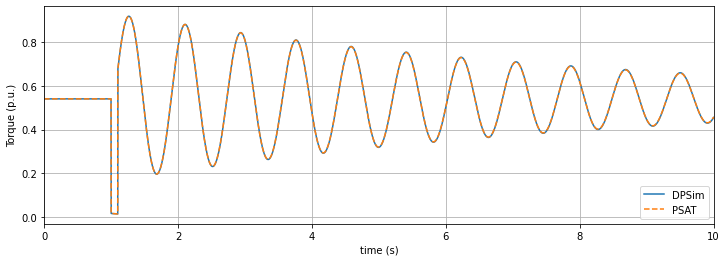

In [13]:
varname_dpsim = "Te"
varname_psat = "p"

rmse_etorque = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### Mechanical Torque

RMSE Tm  = 0.000076 (pu), which is 0.014% of the nominal value = 0.541 (pu) 


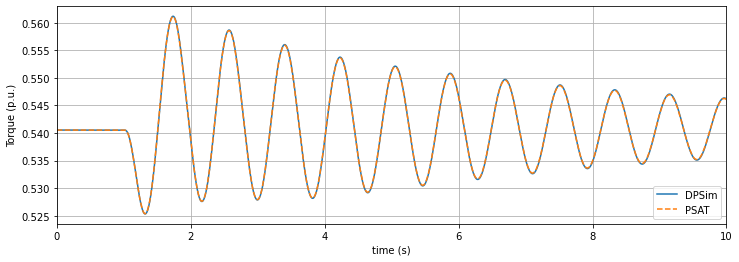

In [14]:
varname_dpsim = "Tm"
varname_psat = "pm"

rmse_mtorque = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $E_d^{'}$

RMSE Edq0_0  = 0.000103 (pu), which is 0.026% of the nominal value = 0.403 (pu) 


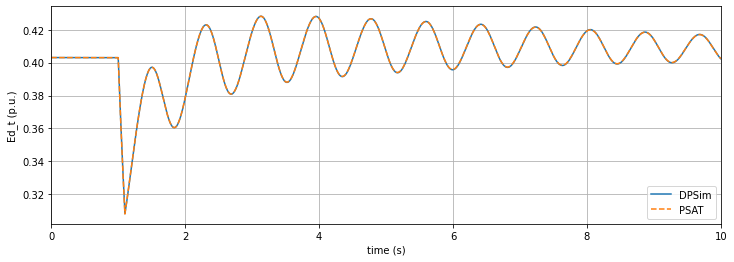

In [15]:
varname_dpsim = "Edq0_0"
varname_psat = "ed_t"

rmse_ed = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $E_q^{'}$

In [ ]:
varname_dpsim = "Edq0_1"
varname_psat = "eq_t"

rmse_eq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $V_d^{'}$

In [ ]:
varname_dpsim = "Vdq0_0"
varname_psat = "vd"

rmse_vd = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $V_q^{'}$

In [ ]:
varname_dpsim = "Vdq0_1"
varname_psat = "vq"

rmse_vq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $I_d$

In [ ]:
varname_dpsim = "Idq0_0"
varname_psat = "id"

rmse_id = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### $I_q$

In [ ]:
varname_dpsim = "Idq0_1"
varname_psat = "iq"

rmse_iq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### Delta

In [ ]:
varname_dpsim = "delta"
varname_psat = "delta"

rmse_delta = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### Mechanical Omega

In [ ]:
varname_dpsim = "w_r"
varname_psat = "omega"

rmse_omega = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

#### Grid voltages

In [ ]:
varname_dpsim = "n1.v"
varname_psat = "V_Bus1"

rmse_v1_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n1.v"
varname_psat = "theta_bus1"

rmse_v1_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n2.v"
varname_psat = "V_Bus3"

rmse_v2_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n2.v"
varname_psat = "theta_bus3"

rmse_v2_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

#### Assert

In [ ]:
tol = 1 # %
tol_i = 6 # %
tol_deg_v1 = 0.2 # deg
tol_deg_v2 = 1e-12 # deg

assert(rmse_etorque<tol)
assert(rmse_mtorque<tol)
assert(rmse_ed<tol)
assert(rmse_eq<tol)
assert(rmse_vd<tol)
assert(rmse_vq<tol)
assert(rmse_id<tol_i)
assert(rmse_iq<tol_i)
assert(rmse_delta<tol)
assert(rmse_omega<tol)
assert(rmse_v1_abs<tol)
assert(rmse_v2_abs<tol)
#assert(rmse_v1_angle<tol_deg_v1)
assert(rmse_v2_angle<tol_deg_v2)